In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from general_functions import *
from spherical_flux import *
%load_ext autoreload
%autoreload
%autoreload 2

plt.style.use(['seaborn-poster'])

f = h5py.File('batsrus_3d_multi_fluid_95000_10k_3deg.h5','r')

dat_x_values = f['x'][:]
dat_y_values = f['y'][:]
dat_z_values = f['z'][:]

def conversion_sphere_to_cart(r,theta,phi):
    '''converts spherical coords to x,y,z
    INPUTS:
    r: in Rm
    theta: (rad)
    phi: (rad)'''

    x = r * np.cos(theta) * np.sin(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(phi)
    return x, y, z

def conversion_cart_to_sphere(x,y,z):
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arctan2(y,x)
    phi = np.arccos(z/r)
    return r,theta,phi

dat_r_values, dat_theta_values, dat_phi_values = conversion_cart_to_sphere(dat_x_values, dat_y_values, dat_z_values)

r_sphere_100km = (3390.0+100.0) / 3390.0 #300km above surface
one_hundred_thirty_km = (130.0) / 3390.0
one_hundred_thirty_five_km = (135.0) / 3390.0
r = r_sphere_100km
lon = np.arange(-45,46,1)
lat = np.arange(-90,91,1)

phi = -1*(lat-90)*np.pi/180.0
theta = lon*np.pi/180.0

phi_v, theta_v = np.meshgrid(phi, theta)

#Make face centers
phi_f = 0.5*(phi_v[1:,1:]+phi_v[:-1,:-1])
theta_f = 0.5*(theta_v[1:,1:]+theta_v[:-1,:-1])
lat_f = -1*phi_f*180/np.pi+90
lon_f = theta_f*180/np.pi

x = (r*np.cos(theta_f)*np.sin(phi_f)).flatten()
y = (r*np.sin(theta_f)*np.sin(phi_f)).flatten()
z = (r*np.cos(phi_f)).flatten()
interpolation_spheres_coords_cartesian = np.array([x,y,z])

In [2]:
number_of_points_in_sphere = np.array([])
interpolated_values_array = np.array([])

for i in range(len(interpolation_spheres_coords_cartesian[0])):
    interp_r = np.sqrt(np.sum(interpolation_spheres_coords_cartesian[:,i]**2))
    r_dist = np.abs(dat_r_values - interp_r)
    distance = ((dat_x_values - interpolation_spheres_coords_cartesian[0,i])**2 +
                (dat_y_values - interpolation_spheres_coords_cartesian[1,i])**2 +
                (dat_z_values - interpolation_spheres_coords_cartesian[2,i])**2)
    
    good_points = np.logical_and(distance<=(one_hundred_thirty_km**2),
                                r_dist<=5.0/3390.0)
    good_x, good_y, good_z, good_distances = dat_x_values[good_points], dat_y_values[good_points], dat_z_values[good_points], distance[good_points]
    number_of_points_in_sphere = np.append(number_of_points_in_sphere, len(good_distances))

    dat_O2_p1_num_dens_values = f['O2_p1_number_density'][:][good_points] #Pulling out values at new indices within interp sphere
    dat_O2_p1_v_x = f['O2_p1_velocity_x'][:][good_points]
    dat_O2_p1_v_y = f['O2_p1_velocity_y'][:][good_points]
    dat_O2_p1_v_z = f['O2_p1_velocity_z'][:][good_points]
    dat_O2_p1_v_tot = np.sqrt(dat_O2_p1_v_x**2 + dat_O2_p1_v_y**2 + dat_O2_p1_v_z**2)

    dat_O_p1_num_dens_values = f['O_p1_number_density'][:][good_points]
    dat_O_p1_v_x = f['O_p1_velocity_x'][:][good_points]
    dat_O_p1_v_y = f['O_p1_velocity_y'][:][good_points]
    dat_O_p1_v_z = f['O_p1_velocity_z'][:][good_points]
    dat_O_p1_v_tot = np.sqrt(dat_O_p1_v_x**2 + dat_O_p1_v_y**2 + dat_O_p1_v_z**2)
    
    interpolation_fields = np.array([dat_O2_p1_num_dens_values, dat_O2_p1_v_x, dat_O2_p1_v_y, dat_O2_p1_v_z, dat_O2_p1_v_tot,
                             dat_O_p1_num_dens_values, dat_O_p1_v_x, dat_O_p1_v_y, dat_O_p1_v_z, dat_O_p1_v_tot])

    distances = good_distances #array of distances from center of sphere to points
    weights = 1.0 / (distances) #1/di factor

    for n in range(len(interpolation_fields)):
        numerator = np.sum(weights*interpolation_fields[n])
        denominator = np.sum(weights)
        interpolated_values_array = np.append(interpolated_values_array, (numerator / denominator))

reshaped_interpolated_values_array = np.reshape(interpolated_values_array, (len(interpolation_spheres_coords_cartesian[0]),10))

In [5]:
plt.style.use(['seaborn-poster'])

In [3]:
interpolation_sphere_coords_spherical = conversion_cart_to_sphere(interpolation_spheres_coords_cartesian[0], interpolation_spheres_coords_cartesian[1], interpolation_spheres_coords_cartesian[2])
lat_f_array = -1* interpolation_sphere_coords_spherical[2] *180/np.pi+90
lon_f_array = interpolation_sphere_coords_spherical[1] *180/np.pi

rounded_lat_f_array = np.round(lat_f_array, 1)
rounded_lon_f_array = np.round(lon_f_array, 1)

O2_num_dens_data = reshaped_interpolated_values_array[:,0]
O2_vx_data = reshaped_interpolated_values_array[:,1]
O2_vy_data = reshaped_interpolated_values_array[:,2]
O2_vz_data = reshaped_interpolated_values_array[:,3]
O2_vtot_data = reshaped_interpolated_values_array[:,4]
O_num_dens_data = reshaped_interpolated_values_array[:,5]
O_vx_data = reshaped_interpolated_values_array[:,6]
O_vy_data = reshaped_interpolated_values_array[:,7]
O_vz_data = reshaped_interpolated_values_array[:,8]
O_vtot_data = reshaped_interpolated_values_array[:,9]

## 25km Radial

Text(0,0.5,'Latitude')

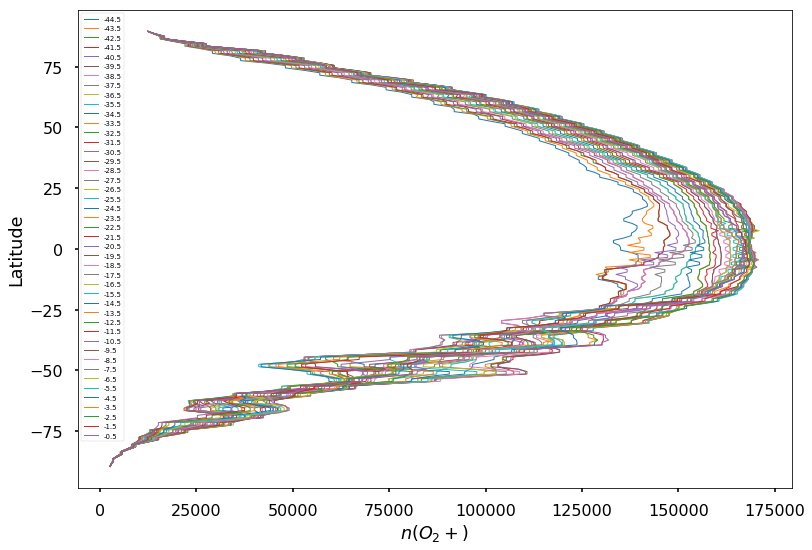

In [35]:
### For loop to calculate and plot num dens values along lon lines
#130km spatial, 25km radial
array_of_plotting_neg_lons = np.arange(-44.5,0.0,1)
for i in range(len(array_of_plotting_neg_lons)):
    num_dens_values = O2_num_dens_data[np.argwhere(rounded_lon_f_array==array_of_plotting_neg_lons[i])]
    lat_values = rounded_lat_f_array[np.argwhere(rounded_lon_f_array==array_of_plotting_neg_lons[i])]
    plt.plot(num_dens_values,lat_values, label=array_of_plotting_neg_lons[i], lw=1)
plt.legend(fontsize='x-small')
plt.xlabel(u'$n(O_2+)$')
plt.ylabel('Latitude')
#plt.savefig('LR_poletopole_line_plot_100km_O2_num_dens_neglon_130sp_25rad.png')

Text(0,0.5,'Latitude')

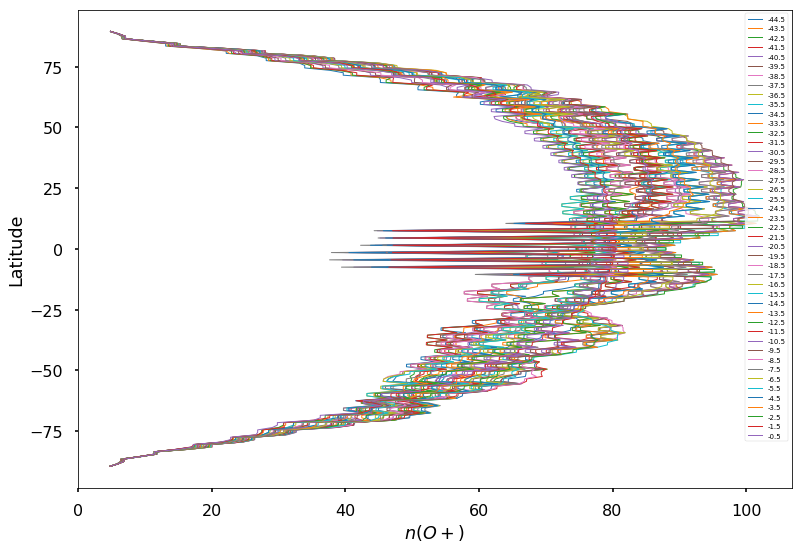

In [28]:
#130km spatial, 25km radial
array_of_plotting_neg_lons = np.arange(-44.5,0.0,1)
for i in range(len(array_of_plotting_neg_lons)):
    O_num_dens_values = O_num_dens_data[np.argwhere(rounded_lon_f_array==array_of_plotting_neg_lons[i])]
    lat_values = rounded_lat_f_array[np.argwhere(rounded_lon_f_array==array_of_plotting_neg_lons[i])]
    plt.plot(O_num_dens_values,lat_values, label=array_of_plotting_neg_lons[i], lw=1)
plt.legend(fontsize='x-small')
plt.xlabel(u'$n(O+)$')
plt.ylabel('Latitude')
#plt.savefig('LR_poletopole_line_plot_100km_O2_num_dens_neglon_130sp_25rad.png')

Text(0,0.5,'Latitude')

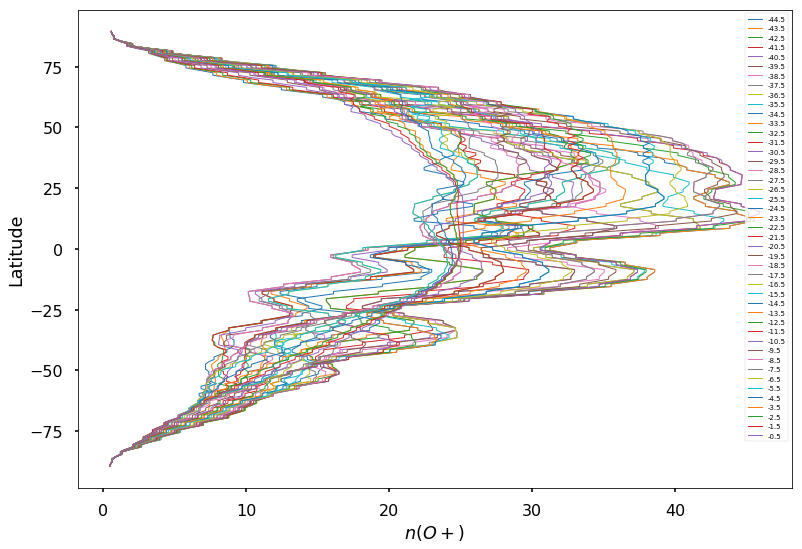

In [6]:
#130km spatial, 25km radial
array_of_plotting_neg_lons = np.arange(-44.5,0.0,1)
for i in range(len(array_of_plotting_neg_lons)):
    O_num_dens_values = O_num_dens_data[np.argwhere(rounded_lon_f_array==array_of_plotting_neg_lons[i])]
    lat_values = rounded_lat_f_array[np.argwhere(rounded_lon_f_array==array_of_plotting_neg_lons[i])]
    plt.plot(O_num_dens_values,lat_values, label=array_of_plotting_neg_lons[i], lw=1)
plt.legend(fontsize='x-small')
plt.xlabel(u'$n(O+)$')
plt.ylabel('Latitude')
#plt.savefig('LR_poletopole_line_plot_100km_O2_num_dens_neglon_130sp_25rad.png')

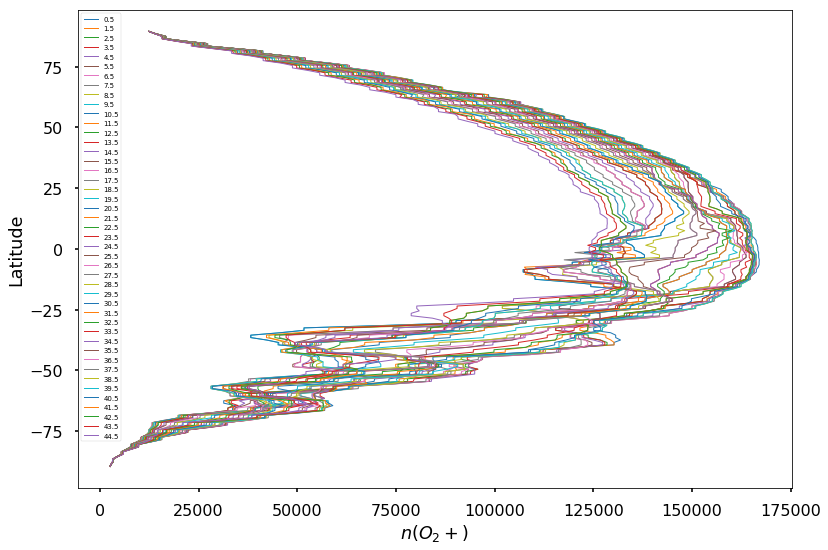

In [9]:
#130km spatial, 25km radial
array_of_plotting_pos_lons = np.arange(0.5, 45.5, 1)
for i in range(len(array_of_plotting_pos_lons)):
    num_dens_values = O2_num_dens_data[np.argwhere(rounded_lon_f_array==array_of_plotting_pos_lons[i])]
    lat_values = rounded_lat_f_array[np.argwhere(rounded_lon_f_array==array_of_plotting_pos_lons[i])]
    plt.plot(num_dens_values,lat_values, label=array_of_plotting_pos_lons[i], lw=1)
plt.legend(fontsize='x-small')
plt.xlabel(u'$n(O_2+)$')
plt.ylabel('Latitude')
plt.savefig('LR_poletopole_line_plot_100km_O2_num_dens_poslon_130sp_25rad.png')

Text(0,0.5,'Latitude')

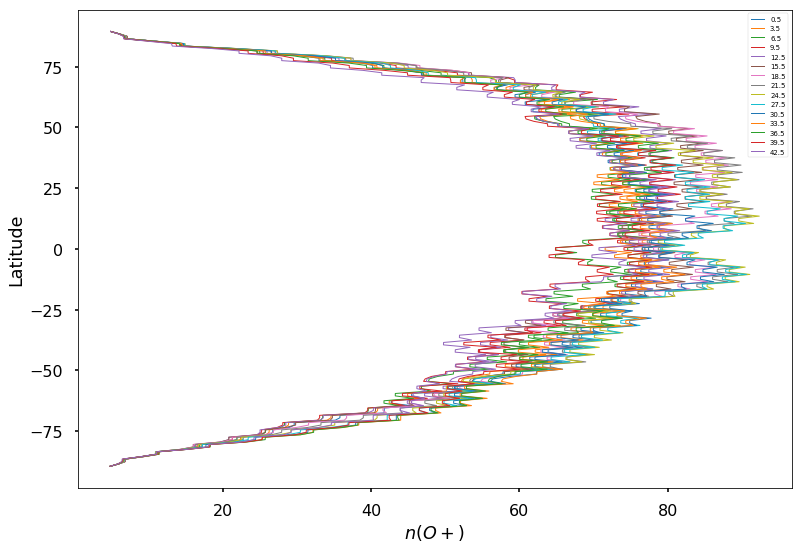

In [37]:
array_of_plotting_pos_lons = np.arange(0.5, 45.5, 3)
for i in range(len(array_of_plotting_pos_lons)):
    O_num_dens_values = O_num_dens_data[np.argwhere(rounded_lon_f_array==array_of_plotting_pos_lons[i])]
    lat_values = rounded_lat_f_array[np.argwhere(rounded_lon_f_array==array_of_plotting_pos_lons[i])]
    plt.plot(O_num_dens_values,lat_values, label=array_of_plotting_pos_lons[i], lw=1)
plt.legend(fontsize='x-small')
plt.xlabel(u'$n(O+)$')
plt.ylabel('Latitude')
#plt.savefig('LR_poletopole_line_plot_100km_O2_num_dens_poslon_130sp_25rad.png')

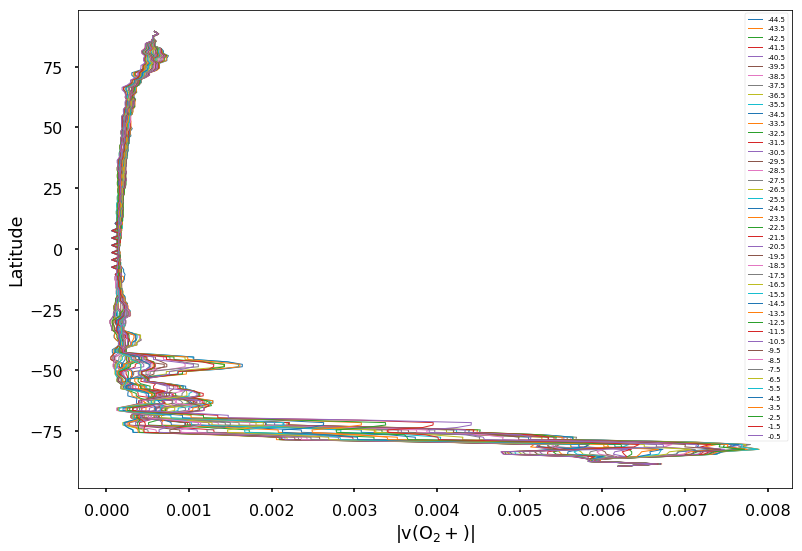

In [15]:
plt.style.use(['seaborn-poster'])
for i in range(len(array_of_plotting_neg_lons)):
    vtot_vals = O2_vtot_data[np.argwhere(rounded_lon_f_array==array_of_plotting_neg_lons[i])]
    lat_values = rounded_lat_f_array[np.argwhere(rounded_lon_f_array==array_of_plotting_neg_lons[i])]
    plt.plot(vtot_vals,lat_values, label=array_of_plotting_neg_lons[i], lw=1)
plt.legend(fontsize='x-small')
plt.xlabel('$\mathrm{|v(O_2+)|}$')
plt.ylabel('Latitude')
plt.savefig('LR_poletopole_line_plot_100km_O2_vtot_neglon_130sp_25rad.png')

Text(0,0.5,'Latitude')

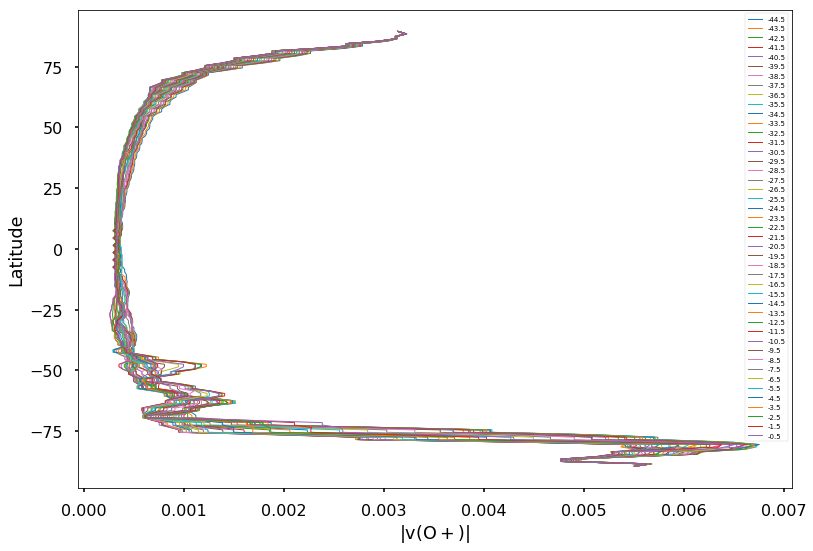

In [34]:
plt.style.use(['seaborn-poster'])
for i in range(len(array_of_plotting_neg_lons)):
    O_vtot_vals = O_vtot_data[np.argwhere(rounded_lon_f_array==array_of_plotting_neg_lons[i])]
    lat_values = rounded_lat_f_array[np.argwhere(rounded_lon_f_array==array_of_plotting_neg_lons[i])]
    plt.plot(O_vtot_vals,lat_values, label=array_of_plotting_neg_lons[i], lw=1)
plt.legend(fontsize='x-small')
plt.xlabel('$\mathrm{|v(O+)|}$')
plt.ylabel('Latitude')
#plt.savefig('LR_poletopole_line_plot_100km_O2_vtot_neglon_130sp_25rad.png')

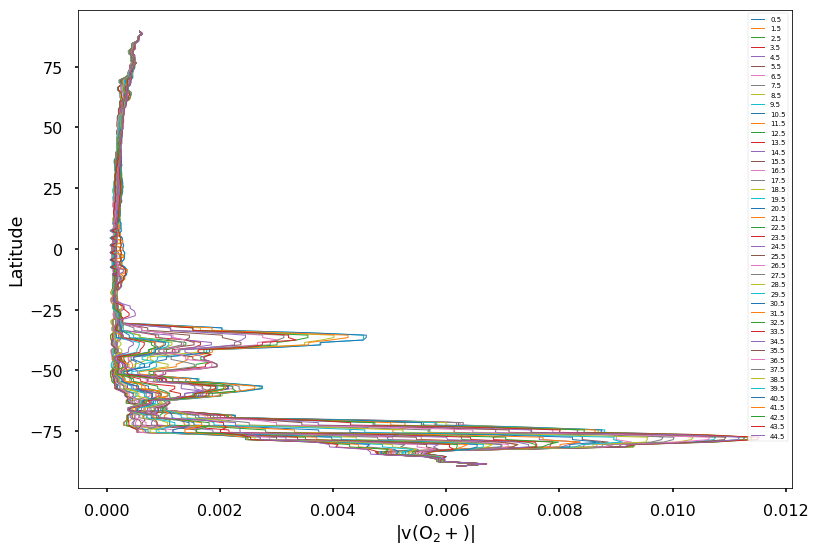

In [16]:
for i in range(len(array_of_plotting_pos_lons)):
    vtot_vals = O2_vtot_data[np.argwhere(rounded_lon_f_array==array_of_plotting_pos_lons[i])]
    lat_values = rounded_lat_f_array[np.argwhere(rounded_lon_f_array==array_of_plotting_pos_lons[i])]
    plt.plot(vtot_vals,lat_values, label=array_of_plotting_pos_lons[i], lw=1)
plt.legend(fontsize='x-small')
plt.xlabel('$\mathrm{|v(O_2+)|}$')
plt.ylabel('Latitude')
plt.savefig('LR_poletopole_line_plot_100km_O2_vtot_poslon_130sp_25rad.png')

## 5km radial

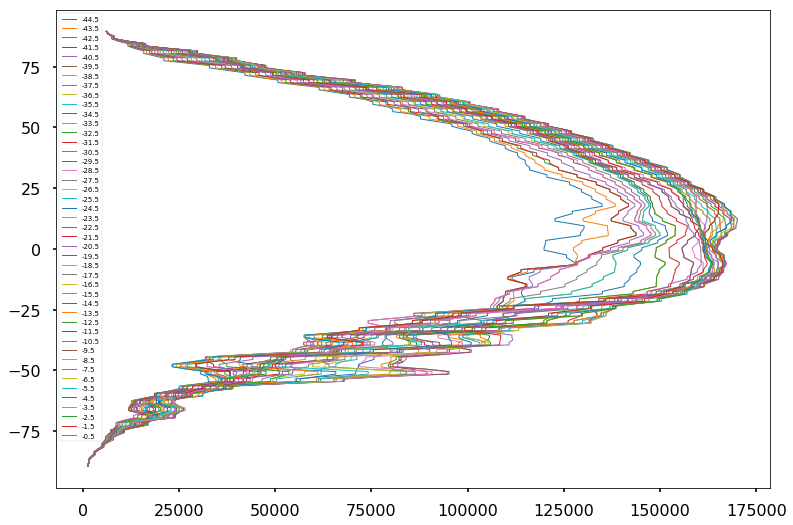

In [9]:
#130km spatial, 5km radial
array_of_plotting_neg_lons = np.arange(-44.5,0.0,1)
for i in range(len(array_of_plotting_neg_lons)):
    num_dens_values = O2_num_dens_data[np.argwhere(rounded_lon_f_array==array_of_plotting_neg_lons[i])]
    lat_values = rounded_lat_f_array[np.argwhere(rounded_lon_f_array==array_of_plotting_neg_lons[i])]
    plt.plot(num_dens_values,lat_values, label=array_of_plotting_neg_lons[i], lw=1)
plt.legend(fontsize='x-small')
plt.savefig('LR_poletopole_line_plot_O2_num_dens_neglon_130sp_5rad.png')

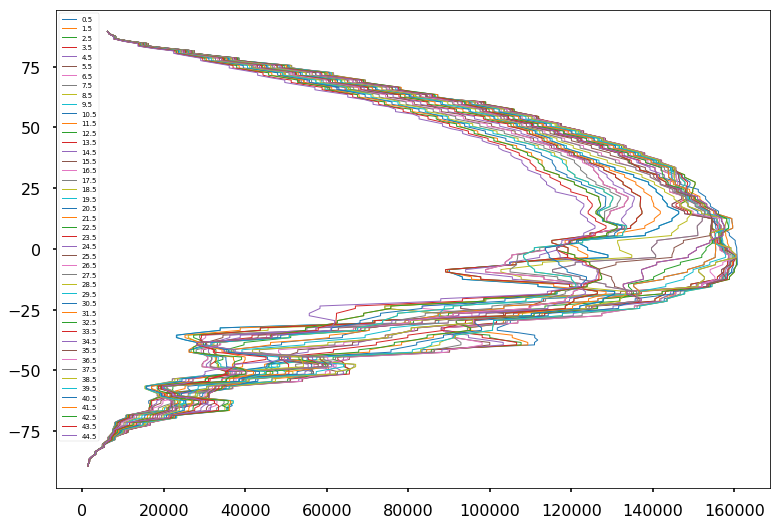

In [10]:
#130km spatial, 5km radial
array_of_plotting_pos_lons = np.arange(0.5, 45.5, 1)
for i in range(len(array_of_plotting_pos_lons)):
    num_dens_values = O2_num_dens_data[np.argwhere(rounded_lon_f_array==array_of_plotting_pos_lons[i])]
    lat_values = rounded_lat_f_array[np.argwhere(rounded_lon_f_array==array_of_plotting_pos_lons[i])]
    plt.plot(num_dens_values,lat_values, label=array_of_plotting_pos_lons[i], lw=1)
plt.legend(fontsize='x-small')
plt.savefig('LR_poletopole_line_plot_O2_num_dens_poslon_130sp_5rad.png')

# Patch Plots

In [9]:
test_xy = lon_f, lat_f

In [18]:
print np.shape(test_xy)
print np.shape(O2_num_dens_data)

(2, 90, 180)
(16200,)


In [19]:
print np.min(O2_num_dens_data)
print np.max(O2_num_dens_data)

2576.0164404403904
170953.19657757864


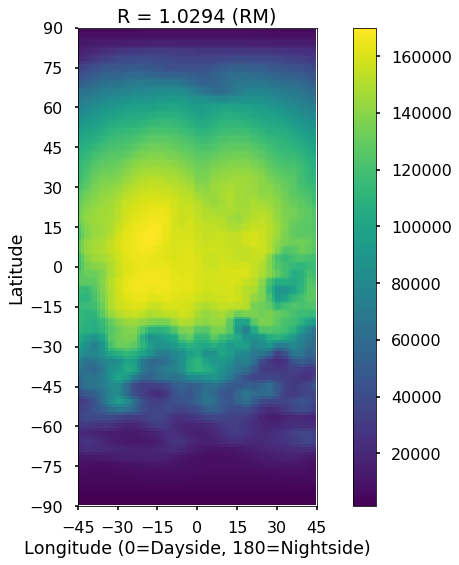

Saving: LR_poletopole_patch_plot_100km_O2_num_dens_130sp_5rad.png


In [16]:
#5km radial
create_plot('O2_p1_number_density',test_xy, O2_num_dens_data, r=1.0294, show=True, override_lims='O2_p1_number_density') #fname='LR_patch_plot_100km_O2_num_dens.png')
create_plot('O2_p1_number_density',test_xy, O2_num_dens_data, r=1.0294, show=False, override_lims='O2_p1_number_density', fname='LR_poletopole_patch_plot_100km_O2_num_dens_130sp_5rad.png')

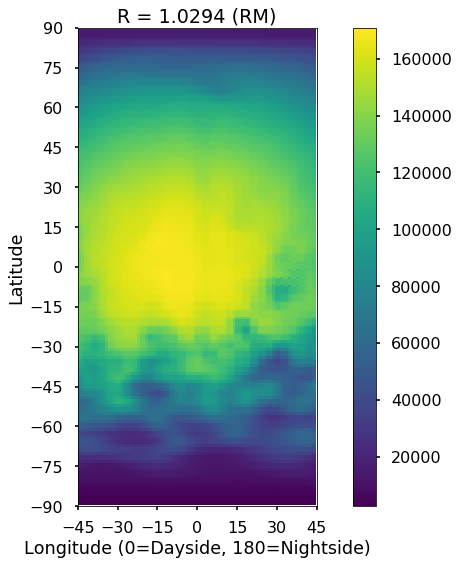

In [9]:
#25km radial
create_plot('O2_p1_number_density',test_xy, O2_num_dens_data, r=1.0294, show=True, override_lims='O2_p1_number_density') #fname='LR_patch_plot_100km_O2_num_dens.png')
create_plot('O2_p1_number_density',test_xy, O2_num_dens_data, r=1.0294, show=False, override_lims='O2_p1_number_density', fname='LR_poletopole_patch_plot_100km_O2_num_dens_130sp_25rad.png')

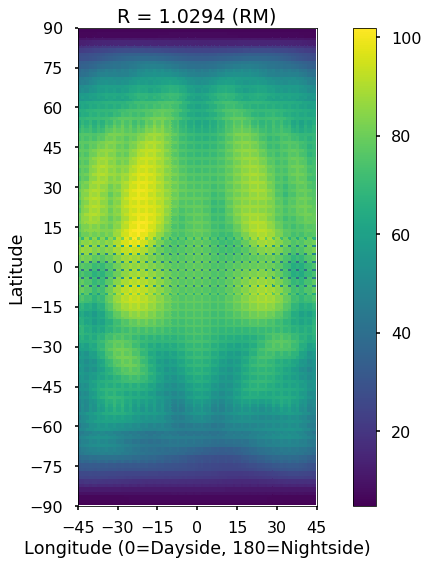

In [39]:
#25km radial
create_plot('O_p1_number_density',test_xy, O_num_dens_data, r=1.0294, show=True, override_lims='O_p1_number_density') #fname='LR_patch_plot_100km_O2_num_dens.png')
#create_plot('O2_p1_number_density',test_xy, O2_num_dens_data, r=1.0294, show=False, override_lims='O_p1_number_density', fname='LR_poletopole_patch_plot_100km_O2_num_dens_130sp_25rad.png')

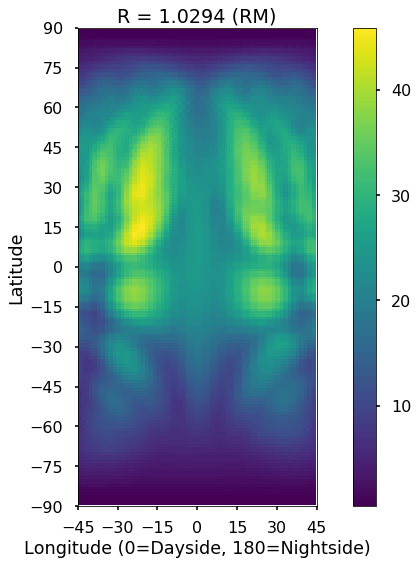

In [10]:
#25km radial
create_plot('O_p1_number_density',test_xy, O_num_dens_data, r=1.0294, show=True, override_lims='O_p1_number_density') #fname='LR_patch_plot_100km_O2_num_dens.png')
#create_plot('O2_p1_number_density',test_xy, O2_num_dens_data, r=1.0294, show=False, override_lims='O_p1_number_density', fname='LR_poletopole_patch_plot_100km_O2_num_dens_130sp_25rad.png')

In [21]:
print np.min(O2_vtot_data)
print np.max(O2_vtot_data)

4.2664497891177705e-05
0.011531634007441751


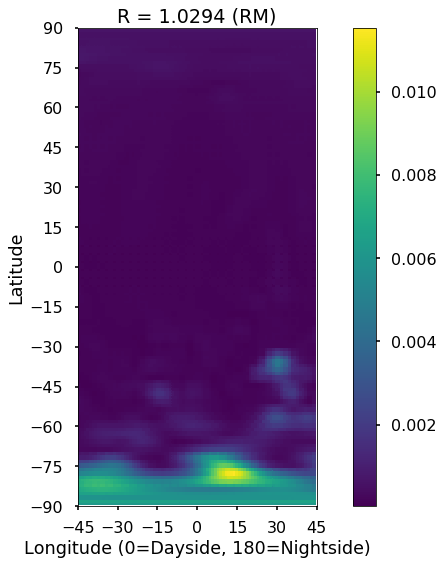

Saving: LR_poletopole_patch_plot_100km_O2_vtot_130sp_25rad.png


In [20]:
#25km radial
create_plot('O2_p1_velocity_total',test_xy, O2_vtot_data, r=1.0294, show=True, override_lims='O2_p1_velocity_total') #fname='LR_patch_plot_100km_O2_num_dens.png')
#create_plot('O2_p1_velocity_total',test_xy, O2_vtot_data, r=1.0294, show=False, override_lims='O2_p1_velocity_total', fname='LR_poletopole_patch_plot_100km_O2_vtot_130sp_25rad.png')